In [26]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from datetime import datetime
import pytz
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize
from scipy.interpolate import interp1d
from scipy import integrate
from scipy.integrate import quad



In [3]:
# Comprehensive bullish strategy building for GME 
gme = yf.Ticker("GME")

### THIS PART GETS THE STOCK PRICE DATA FROM YAHOO FINANCE

### THIS PART GETS ALL THE OPTIONS DATA FOR 06-21 AND 28 

In [4]:
# Step 1: Data Preparation
# Objective: Organize and prepare option data for modeling.
# 
# Extract Data: From your DataFrame, extract the strike prices, implied volatilities, and times to expiration (TTE). Ensure data integrity by handling any missing or anomalous data points.
# Assumption: All reported implied volatilities are accurate and reflect current market conditions.
# Tool: Use Pandas in Python for data manipulation.

opt_06_21 = gme.option_chain('2024-06-21')
calls_06_21 = opt_06_21.calls
df_calls_06_21 = pd.DataFrame(calls_06_21)

df_calls_06_21


,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,GME240621C00002000,2024-06-12 18:33:13+00:00,2.0,25.75,23.00,24.20,-3.50,-11.965812,40,153,8.812504,True,REGULAR,USD
1,GME240621C00003000,2024-06-10 13:44:41+00:00,3.0,22.00,22.00,24.70,0.00,0.000000,2,34,11.898440,True,REGULAR,USD
2,GME240621C00004000,2024-06-07 19:50:42+00:00,4.0,25.02,19.55,23.75,0.00,0.000000,11,14,6.656252,True,REGULAR,USD
3,GME240621C00005000,2024-06-07 17:56:42+00:00,5.0,22.90,20.05,22.25,0.00,0.000000,21,25,8.031255,True,REGULAR,USD
4,GME240621C00006000,2024-06-10 18:02:25+00:00,6.0,17.98,18.05,21.75,0.00,0.000000,1,7,6.289065,True,REGULAR,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,GME240621C00105000,2024-06-12 19:48:58+00:00,105.0,0.76,0.60,0.81,-0.74,-49.333332,1144,750,4.988285,False,REGULAR,USD
72,GME240621C00110000,2024-06-12 19:59:20+00:00,110.0,0.75,0.53,0.74,-0.65,-46.428574,307,2379,5.000004,False,REGULAR,USD
73,GME240621C00115000,2024-06-12 19:59:01+00:00,115.0,0.59,0.52,0.66,-0.80,-57.553960,296,762,5.037113,False,REGULAR,USD
74,GME240621C00120000,2024-06-12 19:58:25+00:00,120.0,0.50,0.49,0.65,-0.80,-61.538460,1542,3932,5.105472,False,REGULAR,USD


In [5]:
puts_06_21 = opt_06_21.puts
df_puts_06_21 = pd.DataFrame(puts_06_21)
df_puts_06_21

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,GME240621P00002000,2024-06-12 15:12:05+00:00,2.0,0.01,0.00,0.01,0.0,0.000000,2,2802,5.500003,False,REGULAR,USD
1,GME240621P00003000,2024-06-10 15:05:43+00:00,3.0,0.01,0.00,0.01,0.0,0.000000,1,679,4.625004,False,REGULAR,USD
2,GME240621P00004000,2024-06-10 14:51:30+00:00,4.0,0.01,0.00,0.01,0.0,0.000000,44,1457,4.000005,False,REGULAR,USD
3,GME240621P00005000,2024-06-12 14:09:50+00:00,5.0,0.01,0.00,0.01,0.0,0.000000,20,3377,3.500001,False,REGULAR,USD
4,GME240621P00006000,2024-06-12 18:19:00+00:00,6.0,0.01,0.00,0.01,0.0,0.000000,193,3257,3.125002,False,REGULAR,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,GME240621P00105000,2024-06-07 18:37:51+00:00,105.0,79.07,79.30,80.55,0.0,0.000000,5,6,4.468754,True,REGULAR,USD
72,GME240621P00110000,2024-06-11 19:21:11+00:00,110.0,83.10,84.25,85.55,0.0,0.000000,10,11,4.523442,True,REGULAR,USD
73,GME240621P00115000,2024-06-12 18:32:07+00:00,115.0,87.50,89.20,90.50,-4.5,-4.891305,1,10,4.515629,True,REGULAR,USD
74,GME240621P00120000,2024-06-07 14:11:35+00:00,120.0,86.15,94.15,95.45,0.0,0.000000,1,3,4.488286,True,REGULAR,USD


In [6]:
opt_06_28 = gme.option_chain('2024-06-28')
calls_06_28 = opt_06_28.calls
df_calls_06_28 = pd.DataFrame(calls_06_28)
df_calls_06_28


,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,GME240628C00005000,2024-06-11 19:41:38+00:00,5.0,24.70,19.75,21.25,0.50,2.066116,1,8,3.437501,True,REGULAR,USD
1,GME240628C00006000,2024-06-07 14:45:37+00:00,6.0,30.00,18.95,20.30,0.00,0.000000,4,3,3.875000,True,REGULAR,USD
2,GME240628C00007000,2024-06-10 19:51:57+00:00,7.0,18.45,17.75,19.30,0.00,0.000000,1,2,2.953128,True,REGULAR,USD
3,GME240628C00008000,2024-06-11 14:43:24+00:00,8.0,17.25,16.95,18.30,0.00,0.000000,1,11,3.132815,True,REGULAR,USD
4,GME240628C00009000,2024-06-11 17:56:56+00:00,9.0,17.00,15.80,17.30,-1.00,-5.555555,2,9,2.539066,True,REGULAR,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,GME240628C00110000,2024-06-12 19:59:19+00:00,110.0,1.05,0.75,1.05,-1.56,-59.770120,260,358,4.109380,False,REGULAR,USD
97,GME240628C00115000,2024-06-12 19:55:21+00:00,115.0,0.96,0.73,1.05,-1.44,-59.999996,103,149,4.183599,False,REGULAR,USD
98,GME240628C00120000,2024-06-12 19:55:12+00:00,120.0,0.87,0.80,1.02,-1.48,-62.978718,742,2236,4.281255,False,REGULAR,USD
99,GME240628C00125000,2024-06-12 19:58:20+00:00,125.0,0.86,0.70,1.02,-1.35,-61.085970,1466,6353,4.308598,False,REGULAR,USD


In [7]:
puts_06_28 = opt_06_28.puts
df_puts_06_28 = pd.DataFrame(puts_06_28)
df_puts_06_28


,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,GME240628P00005000,2024-06-12 16:26:22+00:00,5.0,0.01,0.00,0.01,0.000000,0.000000,74,3884,2.750003,False,REGULAR,USD
1,GME240628P00006000,2024-06-12 15:55:34+00:00,6.0,0.01,0.00,0.02,0.000000,0.000000,4,896,2.562504,False,REGULAR,USD
2,GME240628P00007000,2024-06-12 19:59:28+00:00,7.0,0.01,0.00,0.02,0.000000,0.000000,153,911,2.312504,False,REGULAR,USD
3,GME240628P00008000,2024-06-12 19:36:33+00:00,8.0,0.01,0.00,0.02,-0.010000,-50.000000,1657,1989,2.062505,False,REGULAR,USD
4,GME240628P00009000,2024-06-12 19:34:20+00:00,9.0,0.03,0.02,0.06,-0.030000,-50.000000,2,500,2.234379,False,REGULAR,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,GME240628P00095000,2024-06-07 17:24:23+00:00,95.0,69.14,69.60,71.25,0.000000,0.000000,2,2,3.814454,True,REGULAR,USD
84,GME240628P00100000,2024-06-12 16:17:09+00:00,100.0,71.00,74.55,76.15,-7.000000,-8.974359,5,50,3.841797,True,REGULAR,USD
85,GME240628P00105000,2024-06-07 17:24:15+00:00,105.0,78.75,79.45,81.10,0.000000,0.000000,1,1,3.859375,True,REGULAR,USD
86,GME240628P00120000,2024-06-07 19:09:07+00:00,120.0,94.50,94.30,95.95,0.000000,0.000000,2,2,3.933594,True,REGULAR,USD


In [8]:
# Merge the 4 dataframes
df = pd.concat([df_calls_06_21, df_puts_06_21, df_calls_06_28, df_puts_06_28])
df


,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,GME240621C00002000,2024-06-12 18:33:13+00:00,2.0,25.75,23.00,24.20,-3.500000,-11.965812,40,153,8.812504,True,REGULAR,USD
1,GME240621C00003000,2024-06-10 13:44:41+00:00,3.0,22.00,22.00,24.70,0.000000,0.000000,2,34,11.898440,True,REGULAR,USD
2,GME240621C00004000,2024-06-07 19:50:42+00:00,4.0,25.02,19.55,23.75,0.000000,0.000000,11,14,6.656252,True,REGULAR,USD
3,GME240621C00005000,2024-06-07 17:56:42+00:00,5.0,22.90,20.05,22.25,0.000000,0.000000,21,25,8.031255,True,REGULAR,USD
4,GME240621C00006000,2024-06-10 18:02:25+00:00,6.0,17.98,18.05,21.75,0.000000,0.000000,1,7,6.289065,True,REGULAR,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,GME240628P00095000,2024-06-07 17:24:23+00:00,95.0,69.14,69.60,71.25,0.000000,0.000000,2,2,3.814454,True,REGULAR,USD
84,GME240628P00100000,2024-06-12 16:17:09+00:00,100.0,71.00,74.55,76.15,-7.000000,-8.974359,5,50,3.841797,True,REGULAR,USD
85,GME240628P00105000,2024-06-07 17:24:15+00:00,105.0,78.75,79.45,81.10,0.000000,0.000000,1,1,3.859375,True,REGULAR,USD
86,GME240628P00120000,2024-06-07 19:09:07+00:00,120.0,94.50,94.30,95.95,0.000000,0.000000,2,2,3.933594,True,REGULAR,USD


In [9]:
# The contract symbol is represented like this: GME240628P00128000 of which 240628 is the expiration date, P is the type of contract (P for put, C for call)

# Create a TTE column in days
# Get the current date
current_date = datetime.now(pytz.timezone('US/Eastern'))
current_date = current_date.replace(tzinfo=None)

# Get the expiration date from each contractSymbol and calculate the TTE
df['expiration_date'] = df['contractSymbol'].str[3:9]
df['expiration_date'] = pd.to_datetime(df['expiration_date'], format='%y%m%d')
df['TTE'] = (df['expiration_date'] - current_date).dt.days
df


,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,expiration_date,TTE
0,GME240621C00002000,2024-06-12 18:33:13+00:00,2.0,25.75,23.00,24.20,-3.500000,-11.965812,40,153,8.812504,True,REGULAR,USD,2024-06-21,8
1,GME240621C00003000,2024-06-10 13:44:41+00:00,3.0,22.00,22.00,24.70,0.000000,0.000000,2,34,11.898440,True,REGULAR,USD,2024-06-21,8
2,GME240621C00004000,2024-06-07 19:50:42+00:00,4.0,25.02,19.55,23.75,0.000000,0.000000,11,14,6.656252,True,REGULAR,USD,2024-06-21,8
3,GME240621C00005000,2024-06-07 17:56:42+00:00,5.0,22.90,20.05,22.25,0.000000,0.000000,21,25,8.031255,True,REGULAR,USD,2024-06-21,8
4,GME240621C00006000,2024-06-10 18:02:25+00:00,6.0,17.98,18.05,21.75,0.000000,0.000000,1,7,6.289065,True,REGULAR,USD,2024-06-21,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,GME240628P00095000,2024-06-07 17:24:23+00:00,95.0,69.14,69.60,71.25,0.000000,0.000000,2,2,3.814454,True,REGULAR,USD,2024-06-28,15
84,GME240628P00100000,2024-06-12 16:17:09+00:00,100.0,71.00,74.55,76.15,-7.000000,-8.974359,5,50,3.841797,True,REGULAR,USD,2024-06-28,15
85,GME240628P00105000,2024-06-07 17:24:15+00:00,105.0,78.75,79.45,81.10,0.000000,0.000000,1,1,3.859375,True,REGULAR,USD,2024-06-28,15
86,GME240628P00120000,2024-06-07 19:09:07+00:00,120.0,94.50,94.30,95.95,0.000000,0.000000,2,2,3.933594,True,REGULAR,USD,2024-06-28,15


In [10]:
df.dtypes

contractSymbol                    object
lastTradeDate        datetime64[ns, UTC]
strike                           float64
lastPrice                        float64
bid                              float64
ask                              float64
change                           float64
percentChange                    float64
volume                             int64
openInterest                       int64
impliedVolatility                float64
inTheMoney                          bool
contractSize                      object
currency                          object
expiration_date           datetime64[ns]
TTE                                int64
dtype: object

In [23]:
# Calculate the variance of the logarithmic returns of the stock price over the last 4 years (Initial Variance V0)
# Get the historical data
hist = gme.history(period="4y", interval="1d")

# Calculate the logarithmic returns
hist['log_returns'] = np.log(hist['Close'] / hist['Close'].shift(1))
hist.dropna(inplace=True)
v0 = np.var(hist['log_returns'])

# 2. Theta (Θ) Calculation
# Objective: Calculate the theta of the option.
#
# The long-term average volatility or variance can be estimated as the mean of historical variances over a longer time period:
# Calculation: Use a longer window than for v0 to smooth out short-term fluctuations and capture a longer-term trend.
# θ=Mean(Var(logreturns)) over several years, if available

theta = np.mean(hist['log_returns'].var())

# 3. Kappa (κ) Calculation
# Objective: Calculate the kappa of the option.
#
# Mean reversion rate of volatility:
# Calculation: Estimate the mean reversion rate of volatility by fitting the historical variance to an exponential decay function.
# κ=−log(Var(logreturns)/V0)/TTE

# Fit the historical variance to an exponential decay function
hist['variance'] = hist['log_returns'].var()
hist['variance'] = hist['variance'].shift(-1)
hist.dropna(inplace=True)
hist['TTE'] = (hist.index[-1] - hist.index).days
hist['kappa'] = -np.log(hist['variance'] / v0) / hist['TTE']
kappa = hist['kappa'].mean()

# 4. Rho (ρ) Calculation
# Objective: Calculate the rho of the option.
#
# Correlation between the stock price and the volatility:
# Calculation: Estimate the correlation between the stock price and the volatility by fitting the historical stock prices and variances to a linear regression model.
# ρ=Cov(logreturns,Var(logreturns))/Var(logreturns)

# Fit the historical stock prices and variances to a linear regression model
hist['variance'] = hist['log_returns'].var()
hist['variance'] = hist['variance'].shift(-1)
hist.dropna(inplace=True)
hist['TTE'] = (hist.index[-1] - hist.index).days
hist['rho'] = hist['log_returns'].cov(hist['variance']) / hist['variance'].var()
rho = hist['rho'].mean()

# 5. Sigma (σ) Calculation
# Objective: Calculate the sigma of the option.
#
# Volatility of the stock price:
# Calculation: Use the historical volatility of the stock price as a proxy for the future volatility.
# σ=Std(logreturns)

sigma = hist['log_returns'].std()






In [12]:
strikes = df['strike'].values
iv = df['impliedVolatility'].values
TTE = df['TTE'].values
market_prices = df['lastPrice'].values
strikes, iv, TTE

(array([  2. ,   3. ,   4. ,   5. ,   6. ,   7. ,   8. ,   9. ,  10. ,
         11. ,  12. ,  13. ,  14. ,  15. ,  15.5,  16. ,  16.5,  17. ,
         17.5,  18. ,  18.5,  19. ,  19.5,  20. ,  20.5,  21. ,  21.5,
         22. ,  22.5,  23. ,  23.5,  24. ,  24.5,  25. ,  25.5,  26. ,
         26.5,  27. ,  28. ,  29. ,  30. ,  31. ,  32. ,  33. ,  34. ,
         35. ,  36. ,  37. ,  38. ,  39. ,  40. ,  41. ,  42. ,  43. ,
         44. ,  45. ,  46. ,  47. ,  48. ,  49. ,  50. ,  55. ,  60. ,
         65. ,  70. ,  75. ,  80. ,  85. ,  90. ,  95. , 100. , 105. ,
        110. , 115. , 120. , 125. ,   2. ,   3. ,   4. ,   5. ,   6. ,
          7. ,   8. ,   9. ,  10. ,  11. ,  12. ,  13. ,  14. ,  15. ,
         15.5,  16. ,  16.5,  17. ,  17.5,  18. ,  18.5,  19. ,  19.5,
         20. ,  20.5,  21. ,  21.5,  22. ,  22.5,  23. ,  23.5,  24. ,
         24.5,  25. ,  25.5,  26. ,  26.5,  27. ,  28. ,  29. ,  30. ,
         31. ,  32. ,  33. ,  34. ,  35. ,  36. ,  37. ,  38. ,  39. ,
      

In [13]:
# Step 2: Choosing the Model for Volatility Surface
# Objective: Select an appropriate model to fit the volatility surface based on your data's characteristics.
# 
# Model Options:
# Polynomial Regression: Suitable for datasets where a polynomial can adequately capture the volatility skew/smirk.
# Local Volatility Models: These models are more flexible and can adapt to more complex market conditions.
# Radial Basis Functions (RBF) or Splines: Best for smoothly interpolating across a sparsely populated dataset.

In [14]:
# Explore the data 
# Data Visualization: Plot implied volatilities against strikes and TTE to visually assess the data distribution and identify trends or patterns that might suggest a suitable model.

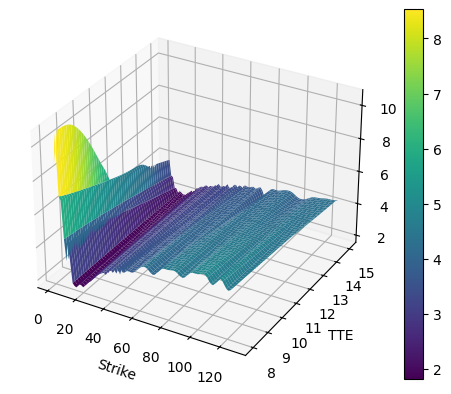

In [15]:
# Plot the implied volatilities against strikes and TTE
# Sample data
strike = np.array(strikes)
tte = np.array(TTE)
iv = np.array(iv)

# Create grid values first
strike_grid, tte_grid = np.meshgrid(np.linspace(strike.min(), strike.max(), 100), 
                                   np.linspace(tte.min(), tte.max(), 100))

# Interpolate unstructured D-dimensional data
iv_grid = griddata((strike, tte), iv, (strike_grid, tte_grid), method='cubic')

# The actual plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(strike_grid, tte_grid, iv_grid, cmap='viridis', edgecolor='none')
ax.set_xlabel('Strike')
ax.set_ylabel('TTE')
ax.set_zlabel('Implied Volatility')
fig.colorbar(surf)
plt.show()



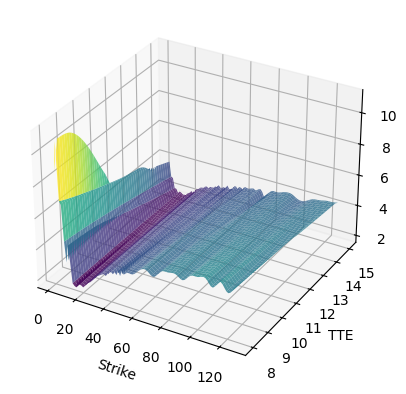

In [16]:
# Contour plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(strike_grid, tte_grid, iv_grid, cmap='viridis', alpha=0.8)
ax.contourf(strike_grid, tte_grid, iv_grid, zdir='z', offset=np.min(iv_grid), cmap='viridis', alpha=0.3)
ax.set_xlabel('Strike')
ax.set_ylabel('TTE')
ax.set_zlabel('Implied Volatility')
plt.show()


In [24]:

# Ensure we have the relevant columns
df = df[['strike', 'lastPrice', 'impliedVolatility', 'TTE']]
df = df.dropna()

# Step 2: Heston Model Calibration

# Heston characteristic function
def heston_char_func(u, t, kappa, theta, sigma, rho, v0, r, S0):
    xi = kappa - rho * sigma * u * 1j
    d = np.sqrt(xi ** 2 + (u ** 2 + 1j * u) * sigma ** 2)
    g1 = (xi - d) / (xi + d)
    g2 = 1 / g1
    
    C = (r * u * 1j * t + (kappa * theta / sigma ** 2) *
         ((xi - d) * t - 2 * np.log((1 - g1 * np.exp(-d * t)) / (1 - g1))))
    
    D = (xi - d) / sigma ** 2 * ((1 - np.exp(-d * t)) / (1 - g1 * np.exp(-d * t)))
    
    return np.exp(C + D * v0 + 1j * u * np.log(S0))

# Heston model option price using the characteristic function
def heston_price(S0, K, T, r, kappa, theta, sigma, rho, v0):
    P1 = lambda u: (np.exp(-1j * u * np.log(K)) * heston_char_func(u - 1j, T, kappa, theta, sigma, rho, v0, r, S0) /
                    (1j * u * S0 ** (1j * u))).real
    P2 = lambda u: (np.exp(-1j * u * np.log(K)) * heston_char_func(u, T, kappa, theta, sigma, rho, v0, r, S0) /
                    (1j * u)).real
    
    int1 = quad(P1, 0, np.inf)[0]
    int2 = quad(P2, 0, np.inf)[0]
    
    return S0 * (0.5 + int1 / np.pi) - np.exp(-r * T) * K * (0.5 + int2 / np.pi)

# Objective function for calibration
def objective(params, S0, market_prices, strikes, T, r):
    kappa, theta, sigma, rho, v0 = params
    prices = np.array([heston_price(S0, K, T, r, kappa, theta, sigma, rho, v0) for K in strikes])
    return np.sum((prices - market_prices) ** 2)

# Market data
S0 = gme.history(period='1d')['Close'][0]  # Current stock price
market_prices = df['lastPrice'].values
strikes = df['strike'].values
T = df['TTE'].values[0]  # Assume all options have the same TTE
r = 0.01  # Risk-free rate

/var/folders/sl/mz3bx1nj3_94rwgrcx6b1pqh0000gn/T/ipykernel_89552/2554710851.py:14: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral = np.real(1 / np.pi * integrate.quad(integrand, 0, np.inf)[0])
/var/folders/sl/mz3bx1nj3_94rwgrcx6b1pqh0000gn/T/ipykernel_89552/2554710851.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  g = (xi - d) / (xi + d)
/var/folders/sl/mz3bx1nj3_94rwgrcx6b1pqh0000gn/T/ipykernel_89552/2554710851.py:5: RuntimeWarning: invalid value encountered in scalar divide
  g = (xi - d) / (xi + d)
/var/folders/sl/mz3bx1nj3_94rwgrcx6b1pqh0000gn/T/ip

KeyboardInterrupt: 

In [ ]:
# Analyze the 21-Jun-2024 call with 30 strike price
